In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'train'
TEST_DIR = 'test'
IMG_SIZE = 50
learn_rate = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(learn_rate, 'tconv-basic')

In [2]:
def label_img(img):
    #conversion to onehot array [cat,dog]
    label = img.split('.')[-3]
    if label == 'cat': return [1,0]
    elif label == 'dog': return [0,1]

In [3]:
def train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [4]:
# train_dat = train_data()
train_dat = np.load('train_data.npy')

In [5]:
def test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
#     shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=learn_rate, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [7]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loded!')

INFO:tensorflow:Restoring parameters from /home/puppy/Desktop/catvsdog/dogsvscats-0.001-tconv-basic.model
model loded!


In [24]:
train = train_dat[:-500]
test = train_dat[-500:]

In [25]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = [i[1] for i in train]

test_X = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [26]:
model.fit({'input': X}, 
          {'targets': y}, 
          n_epoch=15,
          validation_set=({'input': test_X}, 
                          {'targets': test_y}), 
          snapshot_step=500,
          show_metric=True, 
          run_id=MODEL_NAME)

Training Step: 5744  | total loss: 0.24663 | time: 87.792s
| Adam | epoch: 015 | loss: 0.24663 - acc: 0.8937 -- iter: 24448/24500
Training Step: 5745  | total loss: 0.24856 | time: 89.035s
| Adam | epoch: 015 | loss: 0.24856 - acc: 0.8919 | val_loss: 0.65555 - val_acc: 0.7320 -- iter: 24500/24500
--


In [27]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/puppy/Desktop/catvsdog/dogsvscats-0.001-tconv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


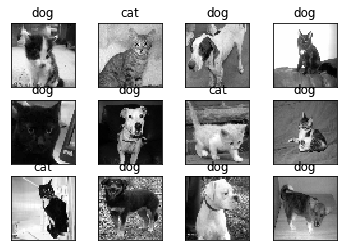

In [10]:
import matplotlib.pyplot as plt

# test_data = test_data()
test_data = np.load('test_data.npy')

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    #cat: [1,0]
    #dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='dog'
    else:
        str_label='cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

In [9]:
with open('submission_file1.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file1.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 12500/12500 [00:36<00:00, 337.98it/s]
